In [4]:
# Notebook config (run this first cell)
from pathlib import Path
import os, sys

BASE = Path(r"C:\Users\Lenovo\Desktop\LY MAJOR PROJECT")
DATA = BASE / "data"
IMAGES = DATA / "images"
POP = DATA / "population"
ROADS = DATA / "roads"
BOUNDARIES = DATA / "boundaries"
PROCESSED = DATA / "processed"
PATCHES = DATA / "patches"
OUTPUTS = BASE / "outputs"

# Create folders (safe)
for p in [PROCESSED, PATCHES, OUTPUTS, OUTPUTS/"maps", OUTPUTS/"charts"]:
    p.mkdir(parents=True, exist_ok=True)

print("Base:", BASE)
print("Processed folder:", PROCESSED)


Base: C:\Users\Lenovo\Desktop\LY MAJOR PROJECT
Processed folder: C:\Users\Lenovo\Desktop\LY MAJOR PROJECT\data\processed


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [6]:
train_data = np.load(PROCESSED / "train.npz")["X"]
val_data   = np.load(PROCESSED / "val.npz")["X"]
test_data  = np.load(PROCESSED / "test.npz")["X"]

print("Train shape:", train_data.shape)
print("Val shape:", val_data.shape)
print("Test shape:", test_data.shape)

input_shape = train_data.shape[1:]
print("Input shape:", input_shape)


Train shape: (2003, 64, 64, 7)
Val shape: (429, 64, 64, 7)
Test shape: (430, 64, 64, 7)
Input shape: (64, 64, 7)


In [10]:
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),

    # 🔁 Decoder
    layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same"),
    layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same"),

    # Output must match input bands = 7
    layers.Conv2D(input_shape[-1], (3,3), activation="linear", padding="same")
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 7)      │         2,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,679 (737.03 KB)

 Trainable params: 188,679 (737.03 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


In [15]:
EPOCHS = 10
BATCH_SIZE = 16

history = model.fit(
    train_data, train_data,   # autoencoder-style (input = target)
    validation_data=(val_data, val_data),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 2.4722e-04 - mae: 0.0091 - val_loss: 3.4215e-04 - val_mae: 0.0108
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2.9006e-04 - mae: 0.0101 - val_loss: 1.9753e-04 - val_mae: 0.0080
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.1492e-04 - mae: 0.0080 - val_loss: 1.3894e-04 - val_mae: 0.0052
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.5946e-04 - mae: 0.0060 - val_loss: 1.5341e-04 - val_mae: 0.0061
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.7649e-04 - mae: 0.0067 - val_loss: 2.0383e-04 - val_mae: 0.0080
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.7542e-04 - mae: 0.0068 - val_loss: 2.1399e-04 - val_mae: 0.0097
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.6554e-04 - mae: 0.0068 - val_loss: 2.3793e-04 - val_mae: 0.0102
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 3.3988e-04 - mae: 0.0111 - val_loss: 2.1527e-04 - 

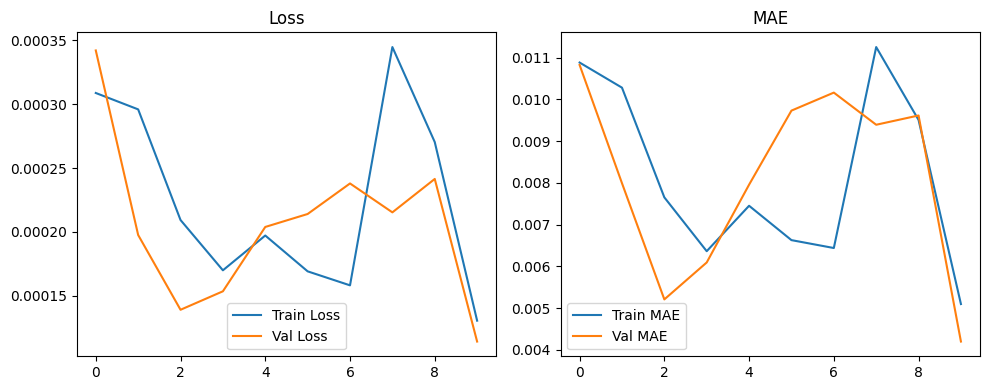

In [16]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.title("MAE")
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# Save trained model
model_path = PROCESSED / "autoencoder_model.h5"
model.save(model_path)

print("✅ Model saved at:", model_path)


✅ Model saved at: C:\Users\Lenovo\Desktop\LY MAJOR PROJECT\data\processed\autoencoder_model.h5


In [18]:
model_path = OUTPUTS / "cnn_model.h5"
model.save(model_path)
print("✅ Model saved at:", model_path)


✅ Model saved at: C:\Users\Lenovo\Desktop\LY MAJOR PROJECT\outputs\cnn_model.h5
